# Goal is to answer the question: can a machine detect a person's gender based on their tweet?

Steps:
1. Get twitter data
2. Clean
3. Analyze and visualize
4. Build model
5. Test model

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import tweepy as tw
import seaborn as sns
import json
import pprint
from matplotlib import pyplot as plt

# Import libraries for WordCloud
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

import nltk
from nltk import PorterStemmer
import textblob
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Connect to twitter API
path_auth = '/Users/allenj/Documents/Keys/auth_twitter.json'
auth = json.loads(open(path_auth).read())
pp = pprint.PrettyPrinter(indent=4)

my_consumer_key = auth['my_consumer_key']
my_consumer_secret = auth['my_consumer_secret']
my_access_token = auth['your_access_token']
my_access_token_secret = auth['my_access_token_secret']

auth = tw.OAuthHandler(my_consumer_key, my_consumer_secret)
auth.set_access_token(my_access_token, my_access_token_secret)
api = tw.API(auth)

type(api)

tweepy.api.API

# 1. Get Twitter data

In [3]:
# Upload list of desired users
# Gender 0 = male, 1 = female
users = pd.read_csv('../Data/users.csv')
users

,user,name,gender,followers_millions,activity,country
0,BarackObama,Barack Obama,0,118,Former U.S. president,United States
1,justinbieber,Justin Bieber,0,111,Musician,Canada
2,katyperry,Katy Perry,1,108,Musician,United States
3,rihanna,Rihanna,1,96,Musician and businesswoman,Barbados
4,taylorswift13,Taylor Swift,1,86,Musician,United States
5,Cristiano,Cristiano Ronaldo,0,84,Footballer,Portugal
6,ladygaga,Lady Gaga,1,81,Musician and actress,United States
7,realDonaldTrump,Donald Trump,0,80,Current U.S. president,United States
8,TheEllenShow,Ellen DeGeneres,1,80,Comedian and television hostess,United States
9,ArianaGrande,Ariana Grande,1,74,Musician and actress,United States


In [4]:
# Get collection of tweets from these usernames and store it into a new dataframe
list = []

for index, row in users.iterrows():
    tweets = api.user_timeline(screen_name=row['user'], count=150, include_rts=False)
    users_text = [[tweet.user.screen_name, tweet.text, row['gender']] for tweet in tweets]
    tweet_text = pd.DataFrame(data=users_text, 
                        columns=["user", "text", "gender"])
    list.append(tweet_text)

# Merge the list    
tweets = pd.concat(list) 
tweets

,user,text,gender
0,BarackObama,My statement on the death of George Floyd: htt...,0
1,BarackObama,"If you believe in a more just, more generous, ...",0
2,BarackObama,"On Memorial Day, we honor those who gave all f...",0
3,BarackObama,And here’s more on the approach Sweden has tak...,0
4,BarackObama,South Korea has focused on testing to guard ag...,0
...,...,...,...
120,NICKIMINAJ,A small word from Jennifer Tilley as #TheBride...,1
121,NICKIMINAJ,https://t.co/66rGZwZ2p4,1
122,NICKIMINAJ,Stop playin wit me like 4 real,1
123,NICKIMINAJ,😂🤣😩 https://t.co/fZriKEQqMf,1


In [5]:
# Count the number of datapoints per person
tweets.groupby(["user", "gender"]).size()

user             gender
Adele            1         145
AnushkaSharma    1         114
ArianaGrande     1          85
AvrilLavigne     1          93
BarackObama      0         139
BeingSalmanKhan  0         148
BillGates        0         144
BrunoMars        0         139
Cristiano        0         150
Drake            0          93
EmmaWatson       1          51
Harry_Styles     0         143
HillaryClinton   1         120
JLo              1         101
KevinHart4real   0         110
KimKardashian    1         106
KingJames        0         113
LilTunechi       0         128
Louis_Tomlinson  0         147
MariahCarey      1         110
MileyCyrus       1         107
NICKIMINAJ       1         125
NiallOfficial    0         120
Oprah            1         137
SrBachchan       0         142
TheEllenShow     1         145
akshaykumar      0         140
aliciakeys       1         121
britneyspears    1         126
ddlovato         1          73
elonmusk         0         127
iamsrk         

# 2. Clean text

In [6]:
# Clean text by removing things
def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

#Remove @ symbol, URL links, and "&amp;"
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['text'], "@[\w]*")
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['clean_text'], "https?:\/\/.*[\r\n]*")
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['clean_text'], "&amp;")
tweets

,user,text,gender,clean_text
0,BarackObama,My statement on the death of George Floyd: htt...,0,My statement on the death of George Floyd:
1,BarackObama,"If you believe in a more just, more generous, ...",0,"If you believe in a more just, more generous, ..."
2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,"On Memorial Day, we honor those who gave all f..."
3,BarackObama,And here’s more on the approach Sweden has tak...,0,And here’s more on the approach Sweden has tak...
4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea has focused on testing to guard ag...
...,...,...,...,...
120,NICKIMINAJ,A small word from Jennifer Tilley as #TheBride...,1,A small word from Jennifer Tilley as #TheBride...
121,NICKIMINAJ,https://t.co/66rGZwZ2p4,1,
122,NICKIMINAJ,Stop playin wit me like 4 real,1,Stop playin wit me like 4 real
123,NICKIMINAJ,😂🤣😩 https://t.co/fZriKEQqMf,1,😂🤣😩


In [7]:
# Remove punctuation, numbers, and special characters
tweets['clean_text'] = tweets['clean_text'].str.replace("[^a-zA-Z#]", " ")
tweets.head(10)

,user,text,gender,clean_text
0,BarackObama,My statement on the death of George Floyd: htt...,0,My statement on the death of George Floyd
1,BarackObama,"If you believe in a more just, more generous, ...",0,If you believe in a more just more generous ...
2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,On Memorial Day we honor those who gave all f...
3,BarackObama,And here’s more on the approach Sweden has tak...,0,And here s more on the approach Sweden has tak...
4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea has focused on testing to guard ag...
5,BarackObama,As all 50 states begin the process of reopenin...,0,As all states begin the process of reopenin...
6,BarackObama,The Class of 2020 is full of the leaders we ne...,0,The Class of is full of the leaders we ne...
7,BarackObama,"As Chicago navigates the health crisis, its re...",0,As Chicago navigates the health crisis its re...
8,BarackObama,"Congrats to the high school Class of 2020, as ...",0,Congrats to the high school Class of as ...
9,BarackObama,Congratulations to the HBCU Class of 2020! Mic...,0,Congratulations to the HBCU Class of Mic...


In [8]:
# Remove short words less than 2
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
tweets.head(10)

,user,text,gender,clean_text
0,BarackObama,My statement on the death of George Floyd: htt...,0,statement death George Floyd
1,BarackObama,"If you believe in a more just, more generous, ...",0,believe more just more generous more democrati...
2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,Memorial honor those gave That takes different...
3,BarackObama,And here’s more on the approach Sweden has tak...,0,here more approach Sweden taken which differs ...
4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea focused testing guard against outb...
5,BarackObama,As all 50 states begin the process of reopenin...,0,states begin process reopening here three arti...
6,BarackObama,The Class of 2020 is full of the leaders we ne...,0,Class full leaders need bend history toward be...
7,BarackObama,"As Chicago navigates the health crisis, its re...",0,Chicago navigates health crisis residents cont...
8,BarackObama,"Congrats to the high school Class of 2020, as ...",0,Congrats high school Class well teachers coach...
9,BarackObama,Congratulations to the HBCU Class of 2020! Mic...,0,Congratulations HBCU Class Michelle proud chan...


In [10]:
# Tokenization
tokenized_tweet = tweets['clean_text'].apply(lambda x: x.split())
tokenized_tweet.head()

0                    [statement, death, George, Floyd]
1    [believe, more, just, more, generous, more, de...
2    [Memorial, honor, those, gave, That, takes, di...
3    [here, more, approach, Sweden, taken, which, d...
4    [South, Korea, focused, testing, guard, agains...
Name: clean_text, dtype: object

In [11]:
# # Stemming
# ps = PorterStemmer()
# tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])
# tokenized_tweet.head()

0                     [statement, death, georg, floyd]
1    [believ, more, just, more, gener, more, democr...
2    [memori, honor, those, gave, that, take, diffe...
3    [here, more, approach, sweden, taken, which, d...
4    [south, korea, focus, test, guard, against, ou...
Name: clean_text, dtype: object

In [12]:
# # Stich tokens back together
# for i in range(len(tokenized_tweet)):
#     tokenized_tweet[i] = ' '.join(str(tokenized_tweet[i]))
          
# tweets['clean_text'] = tokenized_tweet
# tweets.head(10) 

KeyError: 150

In [13]:
tweets['clean_text']

0                           statement death George Floyd
1      believe more just more generous more democrati...
2      Memorial honor those gave That takes different...
3      here more approach Sweden taken which differs ...
4      South Korea focused testing guard against outb...
                             ...                        
120    small word from Jennifer Tilley #TheBrideOfChu...
121                                                     
122                                Stop playin like real
123                                                     
124    only human make laughing simply being aggravat...
Name: clean_text, Length: 5823, dtype: object

In [83]:
tweets

,user,text,gender,clean_text,length
0,BarackObama,My statement on the death of George Floyd: htt...,0,statement death George Floyd,66
1,BarackObama,"If you believe in a more just, more generous, ...",0,believe more just more generous more democrati...,140
2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,Memorial honor those gave That takes different...,140
3,BarackObama,And here’s more on the approach Sweden has tak...,0,here more approach Sweden taken which differs ...,117
4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea focused testing guard against outb...,87
...,...,...,...,...,...
120,NICKIMINAJ,A small word from Jennifer Tilley as #TheBride...,1,small word from Jennifer Tilley #TheBrideOfChu...,110
121,NICKIMINAJ,https://t.co/66rGZwZ2p4,1,,23
122,NICKIMINAJ,Stop playin wit me like 4 real,1,Stop playin like real,30
123,NICKIMINAJ,😂🤣😩 https://t.co/fZriKEQqMf,1,,27


In [101]:
# Export to csv
tweets.to_csv(r'../Data/tweetstest.csv')

# 3. Exploratory data analysis

Text(0.5, 1.0, 'Average tweet length by gender')

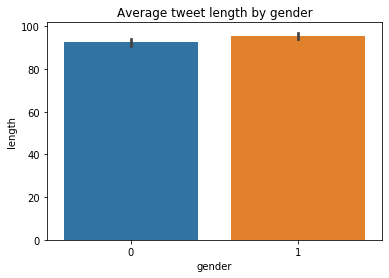

In [14]:
tweets['length'] = tweets['text'].apply(len)
fig1 = sns.barplot('gender', 'length', data=tweets)
plt.title('Average tweet length by gender')

Text(0.5, 1.0, 'Gender counts')

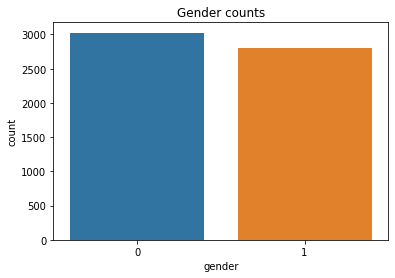

In [15]:
fig2 = sns.countplot(x='gender', data=tweets)
plt.title('Gender counts')

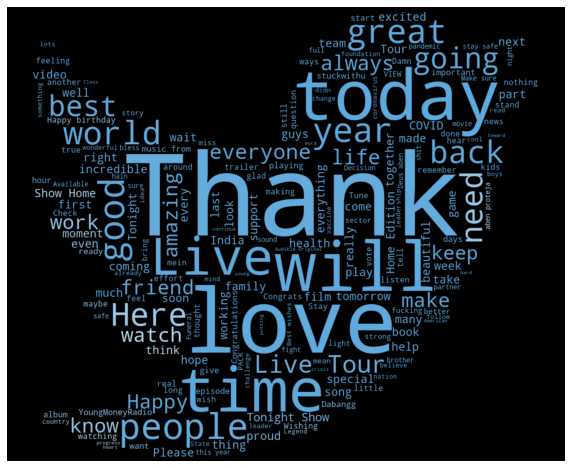

In [16]:
# Plot WordCloud for both genders
# Sort male words
male_words = ' '.join(text for text in tweets['clean_text'][tweets['gender']==0])

# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(male_words)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

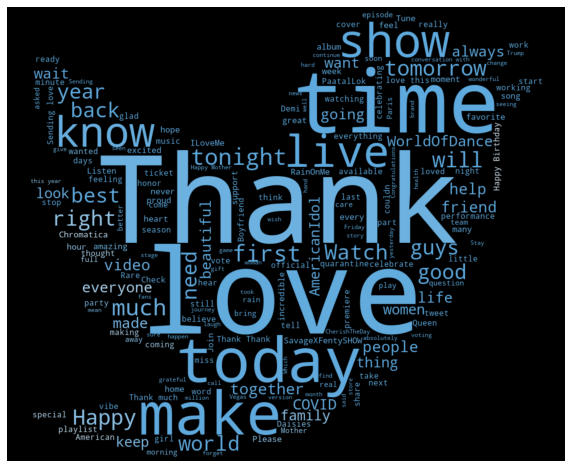

In [17]:
# Sort female words
female_words = ' '.join(text for text in tweets['clean_text'][tweets['gender']==1])

# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(female_words)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

# 4. Model Selectioin and Machine Learning

In [99]:
# Bag-of-Words features
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# Bag-of-Words feature matrix
bow = bow_vectorizer.fit_transform(tweets['clean_text'])
df_bow = pd.DataFrame(bow.todense())
df_bow

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5819,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5820,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# TF-IDF features (Term Frequency-Inverse Document Frequency)
tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')
tfidf_matrix=tfidf.fit_transform(tweets['clean_text'])
df_tfidf = pd.DataFrame(tfidf_matrix.todense())
df_tfidf

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.359505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Using the features from Bag-of-Words Model for training set
train_bow = bow
train_bow.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [27]:
# Using features from TF-IDF for training set,
train_tfidf_matrix = tfidf_matrix
train_tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
# Splitting the data into training and validation set

# Bag-of-Words Features
x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(train_bow,tweets['gender'],test_size=0.2,random_state=2)

In [29]:
# Using TF-IDF features
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix,tweets['gender'],test_size=0.2,random_state=2)

In [30]:
# Logistic Regression
Log_Reg = LogisticRegression(random_state=1,solver='lbfgs')

In [31]:
# Using Bag-of-Words Features
# Fitting the Logistic Regression Model

Log_Reg.fit(x_train_bow,y_train_bow)

LogisticRegression(random_state=1)

In [32]:
# The first part of the list is predicting probabilities for gender:0 (male)
# and the second part of the list is predicting probabilities for gender:1 (female)
prediction_bow = Log_Reg.predict_proba(x_valid_bow)
prediction_bow

array([[0.56872525, 0.43127475],
       [0.90556179, 0.09443821],
       [0.57456071, 0.42543929],
       ...,
       [0.05961416, 0.94038584],
       [0.54420101, 0.45579899],
       [0.10713263, 0.89286737]])

In [90]:
# Calculating the F1 score
# If prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for male tweets and 1 is for female tweets
prediction_int = prediction_bow[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_bow = f1_score(y_valid_bow, prediction_int)

log_bow

0.6973333333333335

In [47]:
# Using TF-IDF Features
Log_Reg.fit(x_train_tfidf,y_train_tfidf)

LogisticRegression(random_state=1)

In [48]:
prediction_tfidf = Log_Reg.predict_proba(x_valid_tfidf)

prediction_tfidf

array([[0.62006795, 0.37993205],
       [0.75384543, 0.24615457],
       [0.61548482, 0.38451518],
       ...,
       [0.16709032, 0.83290968],
       [0.54714166, 0.45285834],
       [0.20699062, 0.79300938]])

In [49]:
# Calculating the F1 score
prediction_int = prediction_tfidf[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_tfidf = f1_score(y_valid_tfidf, prediction_int)

log_tfidf

0.6879795396419438

In [50]:
# Decision Tree
dct = DecisionTreeClassifier(criterion='entropy', random_state=1)

In [51]:
# Using BOW
dct.fit(x_train_bow,y_train_bow)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [52]:
dct_bow = dct.predict_proba(x_valid_bow)

dct_bow

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [0.        , 1.        ],
       [0.54066986, 0.45933014],
       [0.        , 1.        ]])

In [53]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
dct_bow=dct_bow[:,1]>=0.3

# converting the results to integer type
dct_int_bow=dct_bow.astype(np.int)

# calculating f1 score
dct_score_bow=f1_score(y_valid_bow,dct_int_bow)

dct_score_bow

0.6596226415094341

In [54]:
# Using TF-IDF
dct.fit(x_train_tfidf,y_train_tfidf)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [58]:
dct_tfidf = dct.predict_proba(x_valid_tfidf)

dct_tfidf

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       ...,
       [0.        , 1.        ],
       [0.54066986, 0.45933014],
       [0.        , 1.        ]])

In [59]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
dct_tfidf=dct_tfidf[:,1]>=0.3

# converting the results to integer type
dct_int_tfidf=dct_tfidf.astype(np.int)

# calculating f1 score
dct_score_tfidf=f1_score(y_valid_tfidf,dct_int_tfidf)

dct_score_tfidf

0.6257763975155279

In [60]:
# Model Comparison
Algo=['LogisticRegression(Bag-of-Words)','DecisionTree(Bag-of-Words)','LogisticRegression(TF-IDF)','DecisionTree(TF-IDF)']


In [61]:
score = [log_bow,dct_score_bow,log_tfidf,dct_score_tfidf]

compare=pd.DataFrame({'Model':Algo,'F1_Score':score},index=[i for i in range(1,5)])
compare.T


,1,2,3,4
Model,LogisticRegression(Bag-of-Words),DecisionTree(Bag-of-Words),LogisticRegression(TF-IDF),DecisionTree(TF-IDF)
F1_Score,0.697333,0.659623,0.68798,0.625776


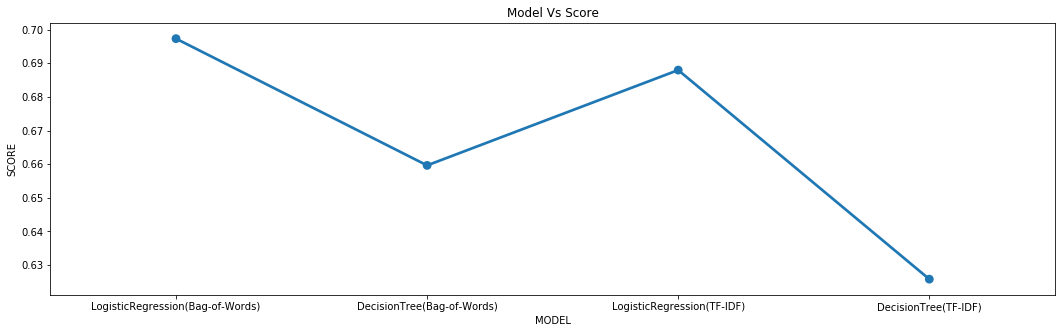

In [62]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1_Score',data=compare)

plt.title('Model Vs Score')
plt.xlabel('MODEL')
plt.ylabel('SCORE')

plt.show()

# Test With Real Text

In [63]:
# Check if there is a fit model

In [64]:
Log_Reg.intercept_, Log_Reg.coef_

(array([-0.18912839]),
 array([[-1.60504402e-01, -2.98986737e-01, -8.96299026e-01,
          4.60291102e-01,  4.38764528e-01,  5.54610139e-01,
          3.07744637e-01,  5.25089958e-01, -1.89307563e-01,
          1.67775388e-01, -5.90774973e-01, -3.45184051e-01,
          4.13027642e-02, -1.85118570e-01,  9.09784566e-02,
         -5.46673891e-01,  5.96884760e-01, -4.47280963e-01,
         -6.70449166e-01, -5.96079224e-01, -1.00765718e-01,
          3.18885378e-01, -2.11375816e-02,  2.46934089e+00,
          5.28192662e-01, -8.44149753e-01, -2.54052672e-01,
          1.03868632e+00,  9.28161563e-01, -7.93610805e-02,
         -5.19318356e-02,  6.69072861e-01,  5.20643530e-02,
          5.85995291e-01, -7.76506612e-01,  5.11492720e-01,
         -5.86525675e-01, -6.46239901e-01, -7.37132723e-01,
          2.40346298e-01, -4.59035453e-01, -1.67713611e-01,
          2.45789490e-01,  1.32693789e-01, -8.58884909e-01,
         -7.39962405e-01,  4.04035379e-01, -5.11644249e-01,
         -3.60518

In [102]:
test_text = pd.read_csv('../Data/tweetstest.csv')
test_text

,Unnamed: 0,user,text,gender,clean_text,length
0,0,BarackObama,My statement on the death of George Floyd: htt...,0,statement death George Floyd,66
1,1,BarackObama,"If you believe in a more just, more generous, ...",0,believe more just more generous more democrati...,140
2,2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,Memorial honor those gave That takes different...,140
3,3,BarackObama,And here’s more on the approach Sweden has tak...,0,here more approach Sweden taken which differs ...,117
4,4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea focused testing guard against outb...,87
...,...,...,...,...,...,...
5818,120,NICKIMINAJ,A small word from Jennifer Tilley as #TheBride...,1,small word from Jennifer Tilley #TheBrideOfChu...,110
5819,121,NICKIMINAJ,https://t.co/66rGZwZ2p4,1,NaN,23
5820,122,NICKIMINAJ,Stop playin wit me like 4 real,1,Stop playin like real,30
5821,123,NICKIMINAJ,😂🤣😩 https://t.co/fZriKEQqMf,1,NaN,27


In [108]:
bow = bow_vectorizer.fit_transform(test_text['clean_text'])
df_bow = pd.DataFrame(bow.todense())
df_bow

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [105]:
prediction_bow = Log_Reg.predict_proba(X)
prediction_bow

ValueError: could not convert string to float: 'statement death George Floyd'

In [74]:
test_text = "this is a test tweet to predict my gender baby boo"

# Bag-of-Words feature matrix
bow = bow_vectorizer.fit_transform('test_text')
df_bow = pd.DataFrame(bow.todense())
df_bow

ValueError: Iterable over raw text documents expected, string object received.

In [73]:
text = "I am so angry"
textBlob = TextBlob(text)
print(f"{textBlob.sentiment}")

Sentiment(polarity=-0.5, subjectivity=1.0)


# ###### 

#### 